# Spotify Hit Songs

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import IsolationForest, RandomForestClassifier

## Data Preprocessing 

In [2]:
with open(r"./data/spotify_hit_songs.csv", 'r', encoding="utf8") as f:
    df_original = pd.read_csv(f)

## Understanding the Data

In [3]:
# Print information about null values in each column
print("Null values per column:")
print(df_original.isnull().sum())

# Print information about duplicates
subset_columns = ['track', 'artist', 'uri']
print("\nCount of duplicates based on track, artist and uri:")
print(df_original[df_original.duplicated(subset=subset_columns)].shape[0])

Null values per column:
track               0
artist              0
uri                 0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
time_signature      0
chorus_hit          0
sections            0
target              0
dtype: int64

Count of duplicates based on track, artist and uri:
422


### Removing Duplicates
Since we found out we have 422 duplicates in our dataset, we want to remove these before performing any calculations on the dataset.

In [4]:
# Remove duplicates based on the specified columns
df = df_original.drop_duplicates(subset=subset_columns, keep='first')

print("Number of rows before removing duplicates:", len(df_original))
print("Number of rows after removing duplicates:", len(df))

# Print information of duplicates again to confirm removal
print("\nCount of duplicates based on track, artist and uri:")
print(df[df.duplicated(subset=subset_columns)].shape[0])

Number of rows before removing duplicates: 41106
Number of rows after removing duplicates: 40684

Count of duplicates based on track, artist and uri:
0


## PCA for Finding Relevant Attributes

In [5]:
attributes = ['danceability','energy','speechiness','acousticness','instrumentalness','liveness','valence']

df_attributes = df[attributes]

# Standardize the data
scaler = StandardScaler()
standardized_data = scaler.fit_transform(df_attributes)

# Perform PCA
pca = PCA()
pca_result = pca.fit_transform(standardized_data)

# Get the loadings of PC1 and PC2
loadings = pca.components_[:2, :]

# Get the attribute names
attribute_names = df_attributes.columns

# Sort attributes based on loadings
pc1_sorted_attributes = [attribute_names[i] for i in (-loadings[0]).argsort()]
pc2_sorted_attributes = [attribute_names[i] for i in (-loadings[1]).argsort()]

# Create list of attributes with the most variation
selected_attributes = [pc1_sorted_attributes[0], pc2_sorted_attributes[0], pc1_sorted_attributes[1], pc2_sorted_attributes[1]]

# Print the first attribute of PC1 and PC2
print("Attribute 1 primarily represented by PC1:", pc1_sorted_attributes[0])
print("Attribute 1 primarily represented by PC2:", pc2_sorted_attributes[0])
print("Attribute 2 primarily represented by PC1:", pc1_sorted_attributes[1])
print("Attribute 2 primarily represented by PC2:", pc2_sorted_attributes[1])

Attribute 1 primarily represented by PC1: acousticness
Attribute 1 primarily represented by PC2: liveness
Attribute 2 primarily represented by PC1: instrumentalness
Attribute 2 primarily represented by PC2: energy


In [21]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=np.random.randint(0, 100))

X_train = df_train[selected_attributes]
y_train = df_train['target'].ravel()

X_test = df_test[selected_attributes]
y_test = df_test['target'].ravel()

cv_values = range(2, 11)

X_full = np.concatenate((X_train, X_test))
y_full = np.concatenate((y_train, y_test))

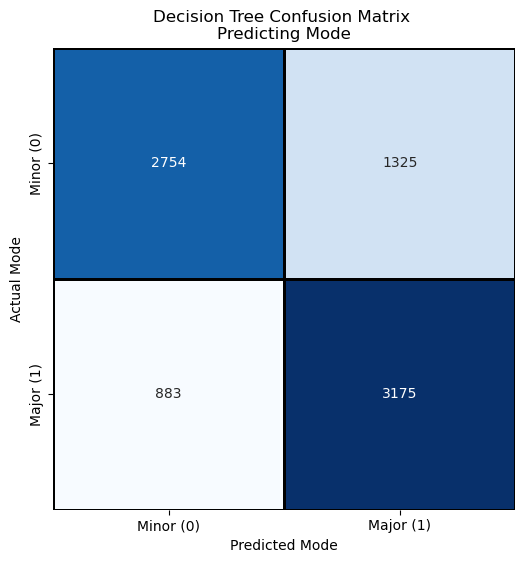

Decision Tree Accuracy: 72.86469214698292
Decision Tree Cross-Validation Score: 72.90089554143407


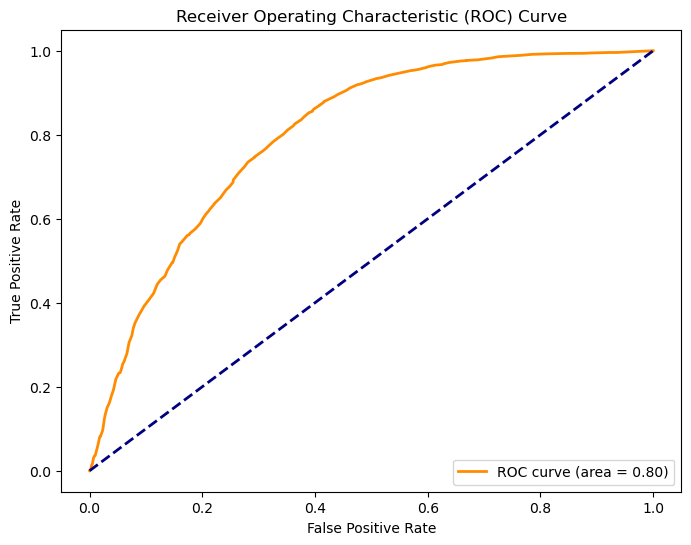

In [22]:
from sklearn.metrics import roc_curve, auc

# Train the Decision Tree Classifier
dtc = DecisionTreeClassifier(criterion='gini', min_samples_split=450)
dtc.fit(X_train, y_train)
dtc_y_pred = dtc.predict(X_test)

# Plot the confusion matrix
dtc_conf_matrix = confusion_matrix(y_test, dtc_y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(dtc_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Minor (0)', 'Major (1)'], yticklabels=['Minor (0)', 'Major (1)'],
            linewidths=1, linecolor='black', square=True)
plt.title("Decision Tree Confusion Matrix \nPredicting Mode")
plt.xlabel("Predicted Mode")
plt.ylabel("Actual Mode")
plt.show()

# Evaluate accuracy score and cross-validation score
dtc_cv_score = cross_val_score(dtc, X_full, y_full, cv=5, scoring='accuracy').mean()
print(f"Decision Tree Accuracy: {dtc.score(X_test, y_test)*100}")
print(f"Decision Tree Cross-Validation Score: {dtc_cv_score*100}")

# Predict probabilities instead of classes for ROC curve
dtc_y_probs = dtc.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, dtc_y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

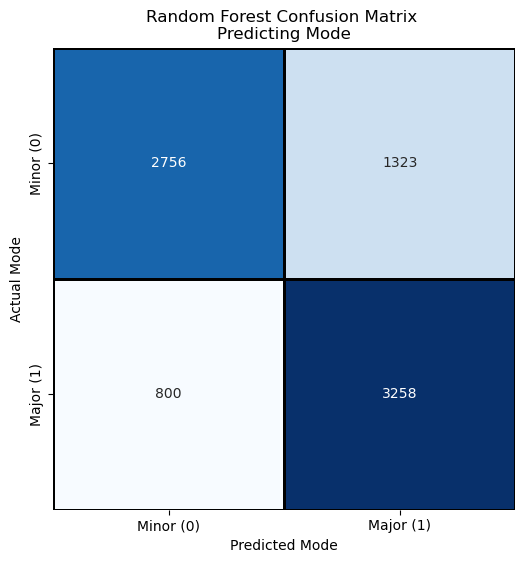

In [ ]:
# Create and fit the Random Forest model
rf = RandomForestClassifier(n_estimators=100, criterion='gini', min_samples_split=450)
rf.fit(X_train, y_train)
rf_y_pred = rf.predict(X_test)

# Plot the confusion matrix
rf_conf_matrix = confusion_matrix(y_test, rf_y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(rf_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Minor (0)', 'Major (1)'], yticklabels=['Minor (0)', 'Major (1)'],
            linewidths=1, linecolor='black', square=True)
plt.title("Random Forest Confusion Matrix \nPredicting Mode")
plt.xlabel("Predicted Mode")
plt.ylabel("Actual Mode")
plt.show()

# Evaluate accuracy
rf_cv_score = cross_val_score(rf, X_full, y_full, cv=5, scoring='accuracy').mean()
print(f"Random Forest Accuracy: {rf.score(X_test, y_test)*100}")
print(f"Decision Tree Cross-Validation Score: {rf_cv_score*100}")

# Predict probabilities instead of classes for ROC curve
rf_y_probs = rf.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_y_probs)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc_rf))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Random Forest')
plt.legend(loc='lower right')
plt.show()

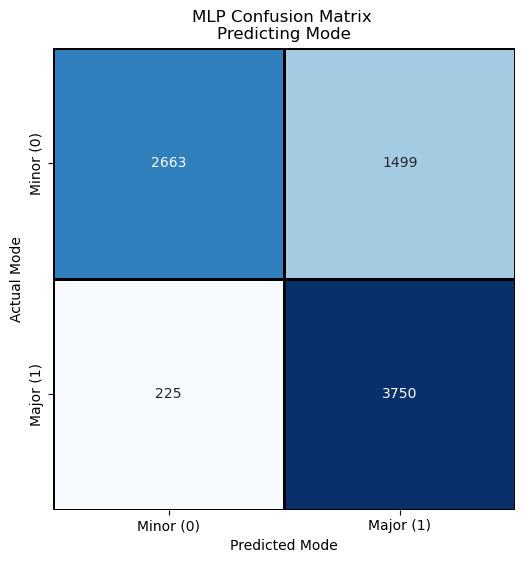

MLP Accuracy: 78.81%


AttributeError: 'MLPClassifier' object has no attribute 'decision_function'

In [19]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Create and fit the MLP (Multi-Layer Perceptron) model
mlp = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42)
mlp.fit(X_train, y_train)

# Predict on the test set
mlp_y_pred = mlp.predict(X_test)

# Plot the confusion matrix
mlp_conf_matrix = confusion_matrix(y_test, mlp_y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(mlp_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Minor (0)', 'Major (1)'], yticklabels=['Minor (0)', 'Major (1)'],
            linewidths=1, linecolor='black', square=True)
plt.title("MLP Confusion Matrix \nPredicting Mode")
plt.xlabel("Predicted Mode")
plt.ylabel("Actual Mode")
plt.show()

# Evaluate accuracy
mlp_accuracy = accuracy_score(y_test, mlp_y_pred)
print(f"MLP Accuracy: {mlp_accuracy * 100:.2f}%")

# Use predict_proba to get predicted probabilities
mlp_y_probs = mlp.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, mlp_y_probs)
roc_auc_mlp = auc(fpr_mlp, tpr_mlp)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_mlp, tpr_mlp, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc_mlp))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - MLP')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Use predict_proba to get predicted probabilities
mlp_y_probs = mlp.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, mlp_y_probs)
roc_auc_mlp = auc(fpr_mlp, tpr_mlp)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_mlp, tpr_mlp, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc_mlp))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - MLP')
plt.legend(loc='lower right')
plt.show()

Hits in minor: 5439
Hits in major: 14692
Flops in minor: 7057
Flops in major: 13496


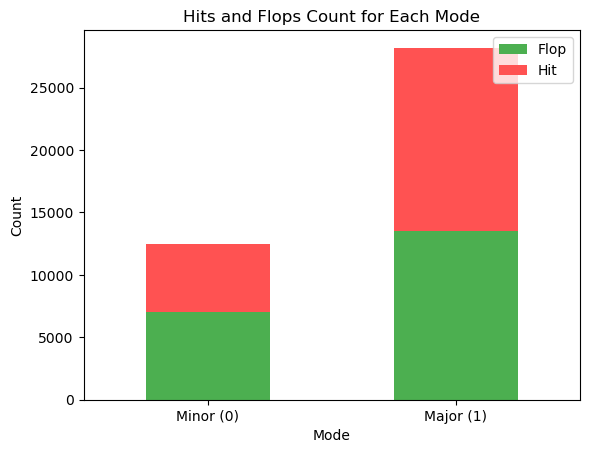

In [40]:
# Group the data by 'mode' and 'target' and count the occurrences
mode_target_counts = df.groupby(['mode', 'target']).size().unstack(fill_value=0)

# Print the counts of hits and flops for each mode
hits_mode_0 = mode_target_counts.loc[0, 1]
hits_mode_1 = mode_target_counts.loc[1, 1]
flops_mode_0 = mode_target_counts.loc[0, 0]
flops_mode_1 = mode_target_counts.loc[1, 0]

print(f"Hits in minor: {hits_mode_0}")
print(f"Hits in major: {hits_mode_1}")
print(f"Flops in minor: {flops_mode_0}")
print(f"Flops in major: {flops_mode_1}")

# Plot the histogram
mode_target_counts.plot(kind='bar', stacked=True, color=['#4CAF50', '#FF5252'])
plt.title('Hits and Flops Count for Each Mode')
plt.xlabel('Mode')
plt.ylabel('Count')
plt.legend(['Flop', 'Hit'], loc='upper right')
plt.xticks(ticks=[0, 1], labels=['Minor (0)', 'Major (1)'], rotation=0)

plt.show()

Hits in minor (normalized): 43.53%
Hits in major (normalized): 52.12%
Flops in minor (normalized): 56.47%
Flops in major (normalized): 47.88%


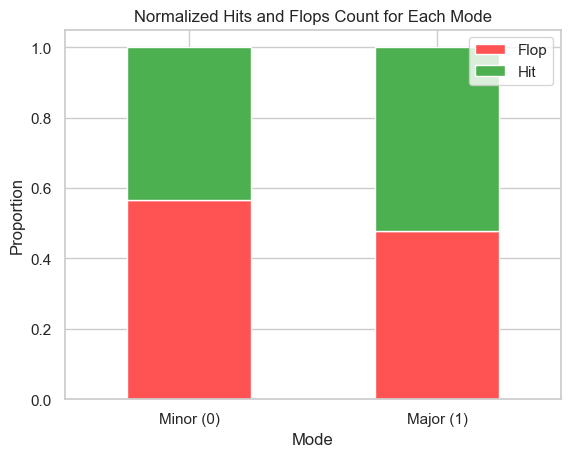

In [103]:

# Assuming df is your DataFrame with 'mode' and 'target' columns
# Group the data by 'mode' and 'target' and count the occurrences
mode_target_counts = df.groupby(['mode', 'target']).size().unstack(fill_value=0)

# Calculate the total number of songs in each mode
total_songs_mode_0 = mode_target_counts.loc[0].sum()
total_songs_mode_1 = mode_target_counts.loc[1].sum()

# Normalize the counts based on the total number of songs in each mode
hits_mode_0_normalized = mode_target_counts.loc[0, 1] / total_songs_mode_0
hits_mode_1_normalized = mode_target_counts.loc[1, 1] / total_songs_mode_1
flops_mode_0_normalized = mode_target_counts.loc[0, 0] / total_songs_mode_0
flops_mode_1_normalized = mode_target_counts.loc[1, 0] / total_songs_mode_1

print(f"Hits in minor (normalized): {hits_mode_0_normalized:.2%}")
print(f"Hits in major (normalized): {hits_mode_1_normalized:.2%}")
print(f"Flops in minor (normalized): {flops_mode_0_normalized:.2%}")
print(f"Flops in major (normalized): {flops_mode_1_normalized:.2%}")

# Plot the normalized histogram
mode_target_counts_normalized = mode_target_counts.div(mode_target_counts.sum(axis=1), axis=0)
mode_target_counts_normalized.plot(kind='bar', stacked=True, color=['#FF5252', '#4CAF50'])
plt.title('Normalized Hits and Flops Count for Each Mode')
plt.xlabel('Mode')
plt.ylabel('Proportion')
plt.legend(['Flop', 'Hit'], loc='upper right')
plt.xticks(ticks=[0, 1], labels=['Minor (0)', 'Major (1)'], rotation=0)

plt.show()


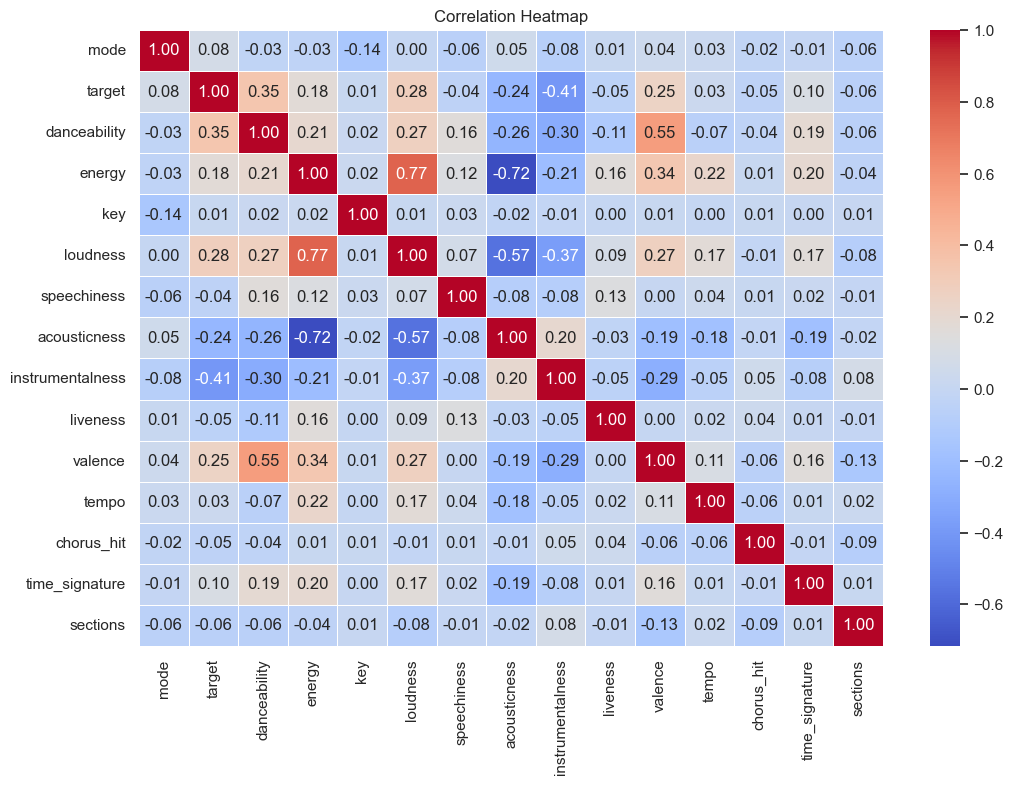

Attributes Correlated with Popularity:
instrumentalness    0.405966
danceability        0.345795
loudness            0.284459
valence             0.251096
acousticness        0.243635
energy              0.175415
time_signature      0.104396
sections            0.061392
liveness            0.051021
chorus_hit          0.045443
speechiness         0.040329
tempo               0.032414
key                 0.009977
Name: target, dtype: float64

Attributes Correlated with Mode:
key                 0.140217
instrumentalness    0.075968
speechiness         0.059416
sections            0.056906
acousticness        0.049986
valence             0.036558
energy              0.033638
danceability        0.031700
tempo               0.027074
chorus_hit          0.022385
time_signature      0.008982
liveness            0.008512
loudness            0.000487
Name: mode, dtype: float64


In [104]:
# Assuming df is your DataFrame with relevant attributes including 'mode' and 'target' columns

# Select relevant columns for correlation analysis
selected_columns = ['mode', 'target', 'danceability', 'energy', 'key', 'loudness', 'speechiness',
                   'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'chorus_hit',
                   'time_signature', 'sections']

# Create a subset DataFrame with selected columns
subset_df = df[selected_columns]

# Calculate the correlation matrix
correlation_matrix = subset_df.corr()

# Plot the heatmap for correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

# Extract correlation values for 'target' (popularity) and 'mode'
popularity_correlation = correlation_matrix['target'].drop(['target', 'mode']).abs()
mode_correlation = correlation_matrix['mode'].drop(['target', 'mode']).abs()

# Sort attributes based on correlation with popularity and mode
popularity_correlation_sorted = popularity_correlation.sort_values(ascending=False)
mode_correlation_sorted = mode_correlation.sort_values(ascending=False)

# Display the sorted attributes and their correlation values
print("Attributes Correlated with Popularity:")
print(popularity_correlation_sorted)

print("\nAttributes Correlated with Mode:")
print(mode_correlation_sorted)


C:\Users\jessi\AppData\Local\Temp\ipykernel_10064\2666649984.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mode'] = pd.Categorical(df['mode'].astype(str), categories=['0', '1'], ordered=True)
C:\Users\jessi\AppData\Local\Temp\ipykernel_10064\2666649984.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['key'] = pd.Categorical(df['key'].astype(str), categories=[str(i) for i in range(12)], ordered=True)
C:\Users\jessi\AppData\Local\Temp\ipykernel_10064\2666649984.py:14: SettingWithCopyWarning: 

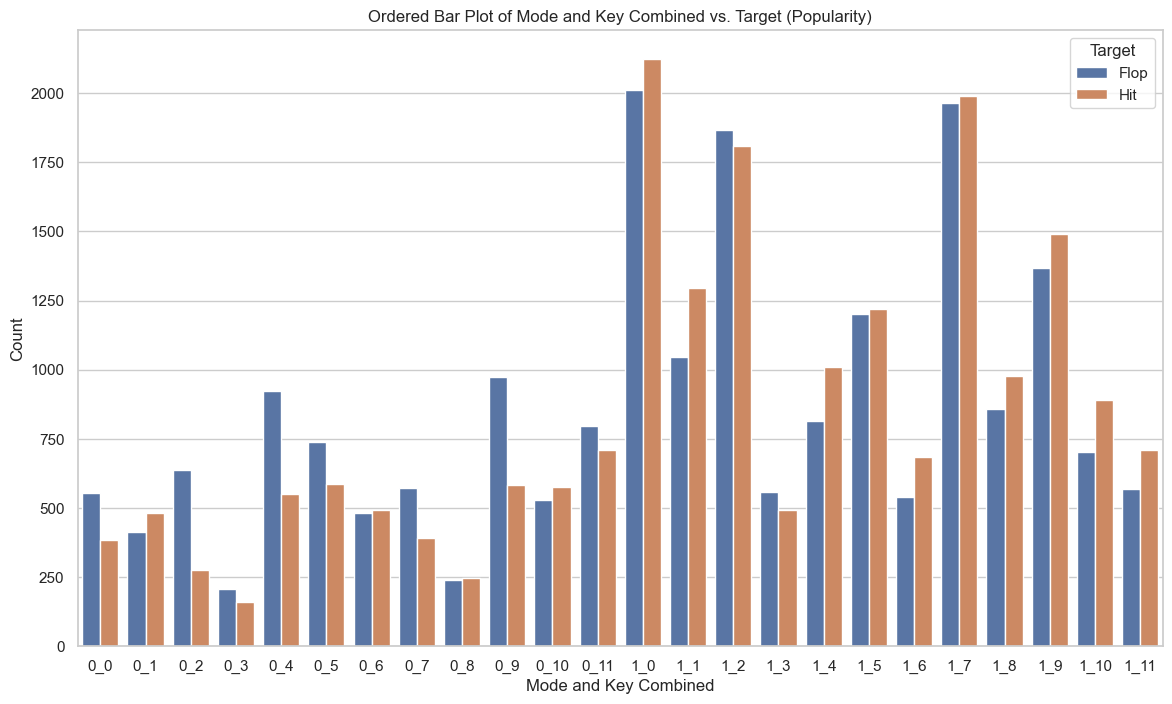

In [129]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame containing 'mode', 'key', 'target'
# Create a new feature combining mode and key using .loc

# Specify the order for 'mode' and 'key'
df['mode'] = pd.Categorical(df['mode'].astype(str), categories=['0', '1'], ordered=True)
df['key'] = pd.Categorical(df['key'].astype(str), categories=[str(i) for i in range(12)], ordered=True)
df.loc[:, 'mode_key_combined'] = df['mode'].astype(str) + '_' + df['key'].astype(str)

# Convert the 'mode_key_combined' column to categorical with the specified order
df['mode_key_combined'] = pd.Categorical(df['mode'].astype(str) + '_' + df['key'].astype(str), categories=[f'{m}_{k}' for m in df['mode'].cat.categories for k in df['key'].cat.categories], ordered=True)

# Create a bar plot
plt.figure(figsize=(14, 8))
sns.countplot(x='mode_key_combined', hue='target', data=df)
plt.xlabel('Mode and Key Combined')
plt.ylabel('Count')
plt.title('Ordered Bar Plot of Mode and Key Combined vs. Target (Popularity)')
plt.legend(title='Target', labels=['Flop', 'Hit'])

plt.show()
